In [1]:
pip install pyspark==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285391 sha256=aae5899efbf8f8dd6255c2f0426f0066f511d2fc9eecd2ce8ca39a303be73bf2
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
pip install pandas

In [3]:
pip install findspark

In [46]:
# Import SparkSession dan fungsi-fungsinya
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, max, to_date, month

# Memberi nama session dengan metode SparkSession.builder.appName().getOrCreate()
spark = SparkSession.builder.appName('DataPenjualanPerusahaan').getOrCreate()

# Inisialisasi dataset yang alan digunakan
data = [('P001', 'Product A', 'Electronics', 10, 200, '2022-01-10'),
        ('P002', 'Product B', 'Electronics', 30, 150, '2022-03-11'),
        ('P003', 'Product C', 'Clothing', 20, 100, '2022-02-10'),
        ('P004', 'Product D', 'Clothing', 15, 120, '2022-02-12'),
        ('P005', 'Product E', 'Kitchen', 25, 90, '2022-04-13'),
        ('P006', 'Product F', 'Kitchen', 5, 300, '2022-01-14')]
columns = ['ProductID', 'ProductName', 'Category', 'Quantity', 'Price', 'Date']

# Mengubah tipe data pada kolom Date menjadi yyyy-MM-dd
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Membuat DataFrame sesuai dengan dataset yang diinisialisasi
df = spark.createDataFrame(data, schema=columns)
df.show()

+---------+-----------+-----------+--------+-----+----------+
|ProductID|ProductName|   Category|Quantity|Price|      Date|
+---------+-----------+-----------+--------+-----+----------+
|     P001|  Product A|Electronics|      10|  200|2022-01-10|
|     P002|  Product B|Electronics|      30|  150|2022-03-11|
|     P003|  Product C|   Clothing|      20|  100|2022-02-10|
|     P004|  Product D|   Clothing|      15|  120|2022-02-12|
|     P005|  Product E|    Kitchen|      25|   90|2022-04-13|
|     P006|  Product F|    Kitchen|       5|  300|2022-01-14|
+---------+-----------+-----------+--------+-----+----------+



In [36]:
# Membuat kolom baru untuk total pendapatan setiap kategori produk perbulan
df = df.withColumn('TotalPendapatanPerbulan', col('Quantity') * col('Price'))

# Membuat kolom Bulan
df = df.withColumn('Bulan', month(col('Date')))

# Menghitung total pendapatan setiap kategori produk perbulan
total = df.groupBy('Category', 'Bulan').agg(
    sum('TotalPendapatanPerbulan').alias('Total Pendapatan Perbulan')
)
total.show()

+-----------+-----+-------------------------+
|   Category|Bulan|Total Pendapatan Perbulan|
+-----------+-----+-------------------------+
|Electronics|    1|                     2000|
|Electronics|    3|                     4500|
|   Clothing|    2|                     3800|
|    Kitchen|    1|                     1500|
|    Kitchen|    4|                     2250|
+-----------+-----+-------------------------+



In [47]:
# Menampilkan jumlah penjualan tertinggi setiap kategori
penjualan_tertinggi = df.groupBy('Category').agg(
    max('Quantity').alias('Penjualan Tertinggi')
)
penjualan_tertinggi.show()

+-----------+-------------------+
|   Category|Penjualan Tertinggi|
+-----------+-------------------+
|Electronics|                 30|
|   Clothing|                 20|
|    Kitchen|                 25|
+-----------+-------------------+



In [44]:
# Analisis tren penjualan bulanan
from pyspark.sql.window import Window
from pyspark.sql import functions as F

windowSpec = Window.partitionBy('Bulan').orderBy('Quantity')
df.withColumn('Rank', F.rank().over(windowSpec)).show()

+---------+-----------+-----------+--------+-----+----------+-----------------------+-----+----+
|ProductID|ProductName|   Category|Quantity|Price|      Date|TotalPendapatanPerbulan|Bulan|Rank|
+---------+-----------+-----------+--------+-----+----------+-----------------------+-----+----+
|     P006|  Product F|    Kitchen|       5|  300|2022-01-14|                   1500|    1|   1|
|     P001|  Product A|Electronics|      10|  200|2022-01-10|                   2000|    1|   2|
|     P004|  Product D|   Clothing|      15|  120|2022-02-12|                   1800|    2|   1|
|     P003|  Product C|   Clothing|      20|  100|2022-02-10|                   2000|    2|   2|
|     P002|  Product B|Electronics|      30|  150|2022-03-11|                   4500|    3|   1|
|     P005|  Product E|    Kitchen|      25|   90|2022-04-13|                   2250|    4|   1|
+---------+-----------+-----------+--------+-----+----------+-----------------------+-----+----+



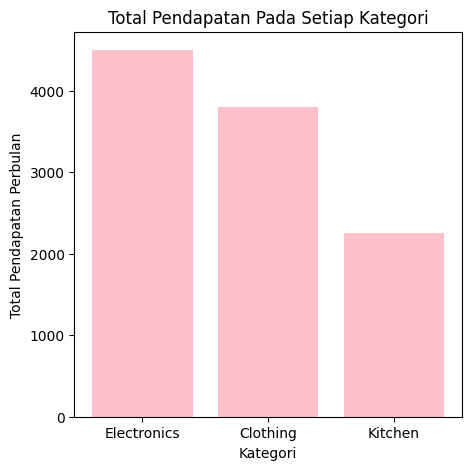

In [45]:
import matplotlib.pyplot as plt

visualisasi = total.toPandas()
plt.figure(figsize=(5,5))
plt.bar(visualisasi["Category"], visualisasi["Total Pendapatan Perbulan"], color='pink')
plt.xlabel("Kategori")
plt.ylabel("Total Pendapatan Perbulan")
plt.title("Total Pendapatan Pada Setiap Kategori")
plt.show()